In [1]:
import numpy as np
import pandas as pd
import sklearn
# Raw URL of the CSV file
data_url = "./BostonHousing.csv"
# Read the CSV file
boston = pd.read_csv(data_url)
boston[:5]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
X = boston.drop('medv', axis=1)
y = boston['medv']

import xgboost
d_param = {
    "learning_rate": 0.01
}
model = xgboost.train(params=d_param,
                      dtrain=xgboost.DMatrix(X, label=y), 
                      num_boost_round=100)

In [3]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
i = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:])

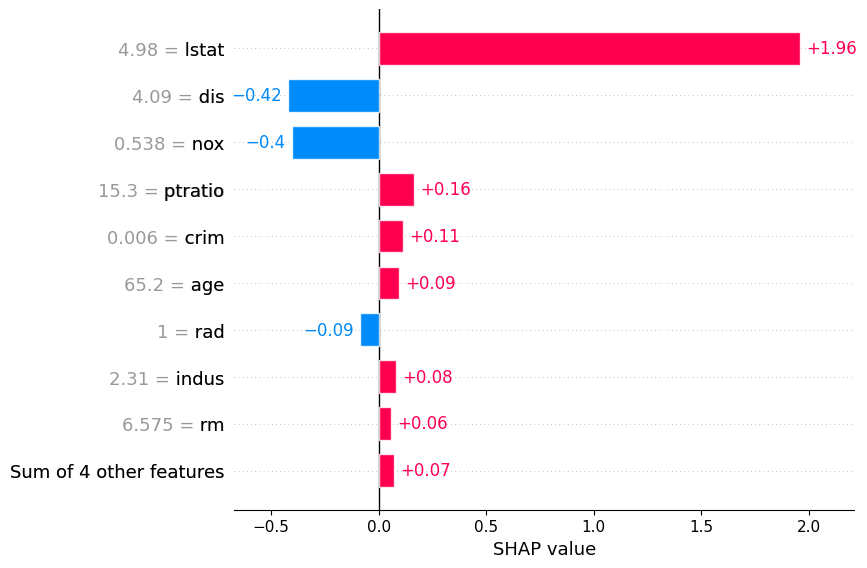

22.412498087322835


In [21]:
# compute SHAP values
explainer_ = shap.Explainer(model, X)
shap_values_ = explainer_(X)
shap.plots.bar(shap_values_[i])
print(shap_values_[i].base_values)
current_shap_values = shap_values_


In [5]:
shap_values_[i].data

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [43]:
counterfactual_instance = [[6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       3.980e+00]]

counterfactual_instance_df = pd.DataFrame(counterfactual_instance, columns=X.columns)

shap_values = explainer.shap_values(counterfactual_instance_df)
counterfactual_shap_values = explainer_(counterfactual_instance_df)
counterfactual_shap_values = counterfactual_shap_values[0]

i = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], counterfactual_instance_df)

counterfactual_shap_values .values =
array([ 1.14609877e-01,  3.17838980e-02,  1.27883119e-01,  7.68877581e-04,
       -4.04397761e-01,  1.05073330e-01,  9.30628452e-02, -4.01124910e-01,
       -8.64345510e-02,  4.52733022e-02,  1.63731645e-01, -6.34751975e-03,
        2.01823290e+00])

.base_values =
22.412498087322835

.data =
array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       3.980e+00])


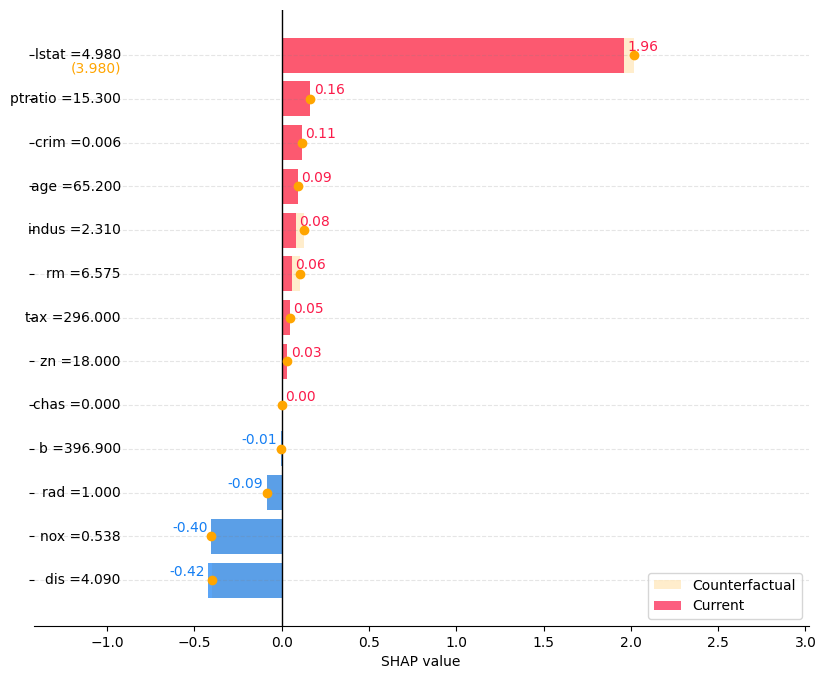

In [44]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and general_case_shap_values are already defined
# And X is the dataset used for feature columns
print("counterfactual_shap_values",counterfactual_shap_values)
# Convert SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values,
    'current_feature_value': current_shap_values.data,
    'counterfactual_value': counterfactual_shap_values.values,
    'counterfactual_feature_value': counterfactual_shap_values.data,
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]

# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot general SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['counterfactual_value'], color='orange', alpha=0.2, label='Counterfactual')

# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, alpha=0.7, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add annotations comparing to the general case
for idx, row in shap_df.iterrows():
    plt.scatter([row['counterfactual_value']], [idx], color='orange', edgecolors='orange', zorder=5)
    # plt.text(row['general_value'], idx + 0.4, f"{row['general_value']:.2f}", color='orange')

# Add feature values next to the y-axis and on the bars
for idx, row in shap_df.iterrows():
    if row['current_value'] >= 0:
        plt.text(row['current_value'] + 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
    else:
        plt.text(row['current_value'] - 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

# plt.title('SHAP Values for Current Instance vs contercounterfactual example')
plt.xlabel('SHAP value')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['counterfactual_value'].min())
max_value = max(shap_df['current_value'].max(), shap_df['counterfactual_value'].max())
# Set y-tick labels with custom formatting
for i, row in shap_df.iterrows():
    ax.text(min_value-0.5, i, f"{row['feature']} ={row['current_feature_value']:.3f}", va='center', ha='right', color='black', fontsize=10)
    if row['counterfactual_feature_value'] != row['current_feature_value']:
        ax.text(min_value -0.5, i + 0.3, f"({row['counterfactual_feature_value']:.3f})", va='center', ha='right', color='orange', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value - 1,right=max_value+1)

# Show the legend
plt.legend()

plt.show()
